/usr/local/lib/python3.9/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.9/dist-packages/pulp/pulp.py:1711: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


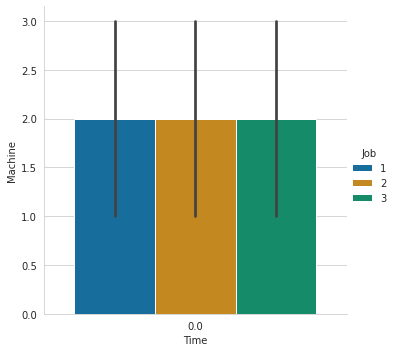

In [ ]:
!pip install pulp
!apt-get install -y -qq glpk-utils

import numpy as np
import pandas as pd
import seaborn as sns
import pulp

def job_shop_scheduling(jobs, machines, processing_times):
    # Define the problem
    problem = pulp.LpProblem('Job Shop Scheduling', pulp.LpMinimize)
    
    # Define decision variables
    start_times = pulp.LpVariable.dicts('Start Time', [(i,j) for i in jobs for j in machines], lowBound=0, cat='Continuous')
    
    # Define objective function
    problem += pulp.lpSum([start_times[(i,j)] for i in jobs for j in machines])
    
    # Add constraints
    for i in jobs:
        for j in machines:
            problem += start_times[(i,j)] >= start_times[(i,j-1)] + processing_times[i][machines.index(j)-1] if machines.index(j) > 0 else 0
            problem += start_times[(i,j)] >= start_times[((i-1)%len(jobs))+1,j] + processing_times[(i-1)%len(jobs)+1][machines.index(j)] if i > 1 else 0
    
    # Solve the problem
    problem.solve()
    
    # Extract the results
    results = np.zeros((len(jobs), len(machines)))
    for i in jobs:
        for j in machines:
            results[i-1][machines.index(j)] = pulp.value(start_times[(i,j)])
    
    # Convert the results to a pandas DataFrame
    df = pd.DataFrame(results, columns=machines, index=jobs)
    
    # Melt the DataFrame to create a long format suitable for visualization
    df = df.reset_index().melt(id_vars=['index'], var_name='Machine', value_name='Start Time')
    df = df.rename(columns={'index':'Job'})
    
    return df

# Define the problem parameters
jobs = [1, 2, 3]
machines = [1, 2, 3]
processing_times = {
    1: [2, 1, 3],
    2: [2, 3, 1],
    3: [1, 2, 2]
}

# Schedule the jobs and visualize the results using a Gantt chart
df = job_shop_scheduling(jobs, machines, processing_times)
sns.set_style('whitegrid')
gantt = sns.catplot(data=df, kind='bar', x='Start Time', y='Machine', hue='Job', 
                    palette=sns.color_palette('colorblind', n_colors=len(jobs)))
gantt.set_axis_labels('Time', 'Machine')
gantt.legend.set_title('Job')
